# Classification of HSPU Ability

In [79]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

RSEED = 42

# Selection of ML Algorithm

In this section one of the 12 datasets (with data of workout scores, body measurements and olympic lifts including imputation of missing data) is taken to find an appropriate classification algorithm.

In [26]:
# load dataset
df = pd.read_csv('./data/prep_hspu_12_19imp_hw_bsimp.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [28]:
# create train and test sets
train_set, test_set = train_test_split(df, test_size=0.3, random_state=RSEED)

# define target and features
y = train_set['w3_hspu_status']
X = train_set.drop(axis=1,columns='w3_hspu_status')

# train test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)

# define numerical features for scaling
scale_cols = ['age', \
              'height','weight', \
              'bs_backsquat','bs_cleanandjerk','bs_snatch','bs_deadlift', \
              'w1_reps_total', \
              'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
              'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
              'w5_reps_total']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[scale_cols])
X_test_scaled = scaler.transform(X_test[scale_cols])

# imputing missing features via KNN
imputer = KNNImputer()
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.fit_transform(X_test_scaled)
    
# concatenate numerical and categorical features
X_train_prep = np.concatenate([X_train_imputed, X_train.drop(scale_cols,axis=1)], axis=1)
X_test_prep = np.concatenate([X_test_imputed, X_test.drop(scale_cols,axis=1)], axis=1)

class_models = []
class_models.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
class_models.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
class_models.append(('Naive Bayes', GaussianNB()))
class_models.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
class_models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))

results_models = []
names = []
for name, model in class_models:
    kfold = KFold(n_splits=5, random_state=RSEED, shuffle=True)
    result = cross_val_score(model, X_train_prep, y_train, cv=kfold, scoring='accuracy')
    results_models.append(result)
    names.append(name)
    print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))

Logistic Regression: Mean Accuracy = 88.69% - SD Accuracy = 0.15%
K Nearest Neighbor: Mean Accuracy = 87.19% - SD Accuracy = 0.14%
Naive Bayes: Mean Accuracy = 76.85% - SD Accuracy = 0.07%
Decision Tree: Mean Accuracy = 84.30% - SD Accuracy = 0.21%
Random Forest: Mean Accuracy = 88.95% - SD Accuracy = 0.14%


In [30]:
results_models_copy = results_models

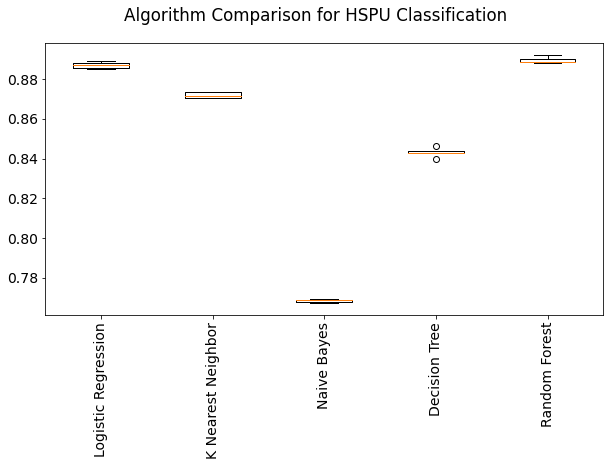

In [31]:
plt.rcParams.update({'figure.figsize': (10,5)})
plt.rcParams.update({'font.size': 14})
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for HSPU Classification')
ax = fig.add_subplot(111)
plt.boxplot(results_models)
plt.xticks(rotation = 90)
ax.set_xticklabels(names)
plt.show()

The best Classifier for this task seems to be Logistic Regression, KNN and the Random Forest Classifier. In the following sections the Random Forest Algorithm will be used because of better interpretability and an accuracy of almost 89%.

---
## Selection of best Dataset

In this section several combinations of data from Data Preparation Notebook are used for the Random Forest algorithm to show the impact of each dataset. At the end the best data combination will be used for the final HSPU classification model.

In [32]:
# define filenames of the datasets in a list
dataset_names = ['prep_hspu_01_19','prep_hspu_02_19imp','prep_hspu_03_19_hw', \
                 'prep_hspu_04_19imp_hw','prep_hspu_05_19_bs','prep_hspu_06_19imp_bs', \
                 'prep_hspu_07_19_hw_bs','prep_hspu_08_19imp_hw_bs','prep_hspu_09_19_bsimp', \
                 'prep_hspu_10_19imp_bsimp','prep_hspu_11_19_hw_bsimp', \
                 'prep_hspu_12_19imp_hw_bsimp']

In [48]:
results = []

for i in range(len(dataset_names)):

    # import dataset
    df = pd.read_csv(f'./data/{dataset_names[i]}.csv')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.sample(frac=0.1)
    
    # define target and features
    y = df['w3_hspu_status']
    X = df.drop(axis=1,columns='w3_hspu_status')
    
    # train test split for model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)
        
    # define numerical features for scaling
    scale_cols = ['age', \
                  'w1_reps_total', \
                  'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
                  'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
                  'w5_reps_total']
    # add heights and weights if necessary
    if 'hw' in dataset_names[i]:
        scale_cols.append('height')
        scale_cols.append('weight')
    # add olympic lifts if necessary
    if 'bs' in dataset_names[i]:
        scale_cols.append('bs_backsquat')
        scale_cols.append('bs_cleanandjerk')
        scale_cols.append('bs_snatch')
        scale_cols.append('bs_deadlift')
    
    # scaling numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[scale_cols])
    X_test_scaled = scaler.transform(X_test[scale_cols])
    
    # imputing missing features via KNN
    imputer = KNNImputer()
    X_train_imputed = imputer.fit_transform(X_train_scaled)
    X_test_imputed = imputer.fit_transform(X_test_scaled)
    
    # concatenate numerical and categorical features
    X_train_prep = np.concatenate([X_train_imputed, X_train.drop(scale_cols,axis=1)], axis=1)
    X_test_prep = np.concatenate([X_test_imputed, X_test.drop(scale_cols,axis=1)], axis=1)
    
    # define and fit the model
    model = RandomForestClassifier(n_estimators=100)
    scoring = 'accuracy'
    kfold = KFold(n_splits=5, random_state=RSEED, shuffle=True)
    cv_results = cross_val_score(model, X_train_prep, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    msg = "%s: %f (%f)" % (dataset_names[i], cv_results.mean(), cv_results.std())
    print(msg)

prep_hspu_01_19: 0.867565 (0.008398)
prep_hspu_02_19imp: 0.883886 (0.003988)
prep_hspu_03_19_hw: 0.866107 (0.003724)
prep_hspu_04_19imp_hw: 0.879318 (0.001662)
prep_hspu_05_19_bs: 0.859817 (0.009608)
prep_hspu_06_19imp_bs: 0.870320 (0.012735)
prep_hspu_07_19_hw_bs: 0.873312 (0.006825)
prep_hspu_08_19imp_hw_bs: 0.871214 (0.010605)
prep_hspu_09_19_bsimp: 0.870361 (0.005200)
prep_hspu_10_19imp_bsimp: 0.886171 (0.002282)
prep_hspu_11_19_hw_bsimp: 0.871758 (0.007010)
prep_hspu_12_19imp_hw_bsimp: 0.888180 (0.006694)


In [49]:
results_best_dataset = results

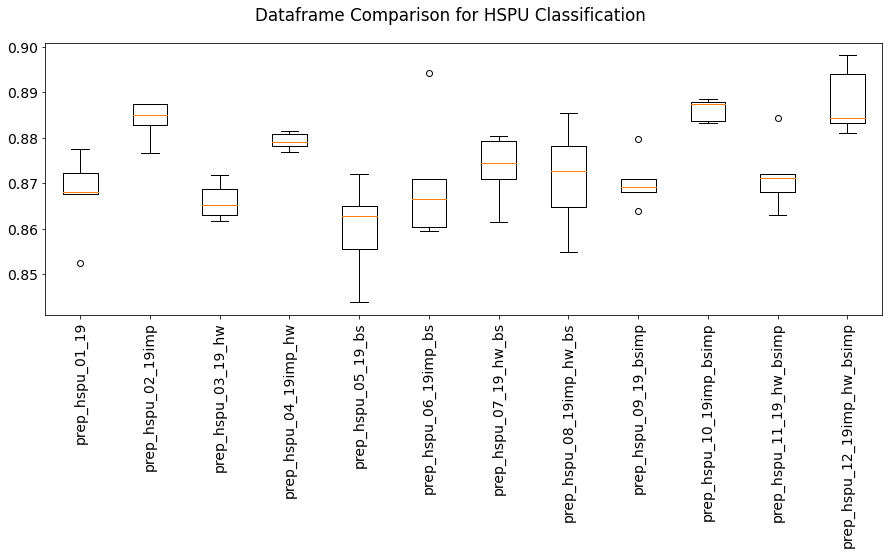

In [50]:
plt.rcParams.update({'figure.figsize': (15,5)})
plt.rcParams.update({'font.size': 14})
# Compare Dataframes
fig = plt.figure()
fig.suptitle('Dataframe Comparison for HSPU Classification')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xticks(rotation = 90)
ax.set_xticklabels(dataset_names)
plt.show()

XXX

---
## Model Building

With the help of the selected algorithm and the most promising dataset, in this section the first Random Forest Classification model is build and analyzed.

In [53]:
# load the dataset
df_cl = pd.read_csv('./data/prep_hspu_10_19imp_bsimp.csv')
df_cl = df_cl.loc[:, ~df_cl.columns.str.contains('^Unnamed')]
df_cl = df_cl.sample(frac=0.1)
# create train and test sets
train_set, test_set = train_test_split(df_cl,test_size=0.3,random_state=RSEED)
# define target and features
y = train_set['w3_hspu_status']
X = train_set.drop(axis=1,columns='w3_hspu_status')
# train test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)
# define numerical features for scaling
scale_cols = ['age', \
              'bs_backsquat','bs_cleanandjerk','bs_snatch','bs_deadlift', \
              'w1_reps_total', \
              'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
              'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
              'w5_reps_total']
# scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[scale_cols])
X_test_scaled = scaler.transform(X_test[scale_cols])
# imputing missing features via KNN
imputer = KNNImputer()
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.fit_transform(X_test_scaled)
# concatenate numerical and categorical features
X_train_prep = np.concatenate([X_train_imputed,X_train.drop(scale_cols,axis=1)],axis=1)
X_test_prep = np.concatenate([X_test_imputed,X_test.drop(scale_cols,axis=1)],axis=1)

In [96]:
print('Dummy Classifier:')
print('Accuracy to beat:',
      round(100*df_cl[df_cl['w3_hspu_status']==0]['w3_hspu_status'].count()/df_cl['w3_hspu_status'].count(),2),
      '%')

Dummy Classifier:
Accuracy to beat: 65.96 %


In [54]:
# define the classification model
model_cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, \
                                  bootstrap = True, random_state=RSEED)
model_cl.fit(X_train_prep, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [55]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_cl.score(X_train_prep, y_train), 
                                                                                              model_cl.oob_score_,
                                                                                              model_cl.score(X_test_prep, y_test)))

Training Accuracy: 0.9999 
OOB Accuracy: 0.8819 
Validation Accuracy: 0.8827


---
## Hyperparameter Tuning

In [69]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [5,10,15],
              "max_features" : [5,10,15],
              "max_leaf_nodes" : [400,500,600],
              "max_samples" : [None],
              #"min_impurity_decrease" : [0.001],
              #"min_impurity_split" : [10],
              #"min_samples_leaf" : [1],
              #"min_samples_split" : [2],
              #"min_weight_fraction_leaf" : [0.00000000001],
              #"n_estimators" : [100]
             }
scoring = 'accuracy'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model_cl, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)

In [70]:
gs.fit(X_train_prep, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [5, 10, 15],
                         'max_leaf_nodes': [400, 500, 600],
                         'max_samples': [None]},
             scoring='accuracy', verbose=5)

In [71]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=15, max_features=5, max_leaf_nodes=500,
                       n_jobs=-1, oob_score=True, random_state=42)

 The best score across ALL searched params:
 0.8858875124955776

 The best parameters across ALL searched params:
 {'max_depth': 15, 'max_features': 5, 'max_leaf_nodes': 500, 'max_samples': None}


In [72]:
model = RandomForestClassifier(
    max_depth = 15,
    max_features = 5,
    max_leaf_nodes = 500,
    max_samples = None,
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model.fit(X_train_prep, y_train)

RandomForestClassifier(max_depth=15, max_features=5, max_leaf_nodes=500,
                       n_jobs=-1, oob_score=True, random_state=42)

In [73]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model.score(X_train_prep, y_train), 
                                                                                              model.oob_score_,
                                                                                              model.score(X_test_prep, y_test)))

Training Accuracy: 0.9428 
OOB Accuracy: 0.8846 
Validation Accuracy: 0.8817


---
## Visualization

In [76]:
# get score for test set
y_test_set = test_set['w3_hspu_status']
X_test_set = test_set.drop(axis=1,columns='w3_hspu_status')
X_test_set_scaled = scaler.transform(X_test_set[scale_cols])
X_test_set_imputed = imputer.fit_transform(X_test_set_scaled)
X_test_set_prep = np.concatenate([X_test_set_imputed,X_test_set.drop(scale_cols,axis=1)],axis=1)
y_pred = model.predict(X_test_set_prep)

In [98]:
model.score(X_test_set_prep, y_test_set)

0.8826309570697125

In [77]:
matrix = confusion_matrix(y_test_set, y_pred)
matrix

array([[6192,  502],
       [ 690, 2772]])

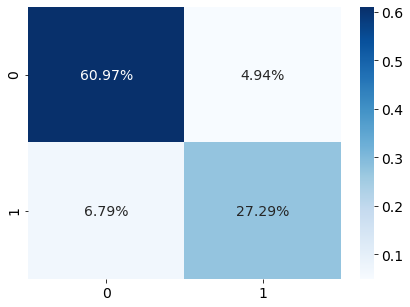

In [84]:
plt.rcParams.update({'figure.figsize': (7,5)})
plt.rcParams.update({'font.size': 14})
sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues');

XXX